In [724]:
#ANALYZING DATA
#some empty spaces, maybe some duplicates, 
#1IMPORT all libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt







In [725]:
data= pd.read_csv("SalaryData.csv") #read the csv file

data.drop(columns='Job Title', inplace=True)
#Let's clean raw data
#1) impute missing values
#2) drop dulpicates 
#3) one-hot encoding catergoical data
#4) remove outliers
#5)combine highly correlated data

#Solution 1 : impute missing values
#calculate the missing data 

#What we saw? two rows are missing from the dataset

data.head()




,Age,Gender,Education Level,Years of Experience,Salary
0,32.0,Male,Bachelor's,5.0,90000.0
1,28.0,Female,Master's,3.0,65000.0
2,45.0,Male,PhD,15.0,150000.0
3,36.0,Female,Bachelor's,7.0,60000.0
4,52.0,Male,Master's,20.0,200000.0


In [726]:

#Solution 1 : impute missing values
#calculate the missing data 
#What we saw? two rows are missing from the dataset
data.dropna(inplace=True)
data.isnull().sum()


#check: we all good 

Age                    0
Gender                 0
Education Level        0
Years of Experience    0
Salary                 0
dtype: int64

In [727]:
#Solution 2: Drop dulpicates
data.drop_duplicates(inplace=True) 

In [728]:
#Solution 3:  one-hot encoding catergoical data

#whats werid about this data,is the name is not fit for ml
#let's rename
data.rename(columns={
    "Education Level": "edu_level",
    "Gender" : "gend"
},
    inplace=True
)

data.head()
#check : we good


#check: if it works , now transfer data




,Age,gend,edu_level,Years of Experience,Salary
0,32.0,Male,Bachelor's,5.0,90000.0
1,28.0,Female,Master's,3.0,65000.0
2,45.0,Male,PhD,15.0,150000.0
3,36.0,Female,Bachelor's,7.0,60000.0
4,52.0,Male,Master's,20.0,200000.0


In [729]:

data_encoded = pd.get_dummies(data=data, columns=['edu_level', 'gend'], dtype=int)



In [730]:
data_encoded.isnull().sum()

Age                     0
Years of Experience     0
Salary                  0
edu_level_Bachelor's    0
edu_level_Master's      0
edu_level_PhD           0
gend_Female             0
gend_Male               0
dtype: int64

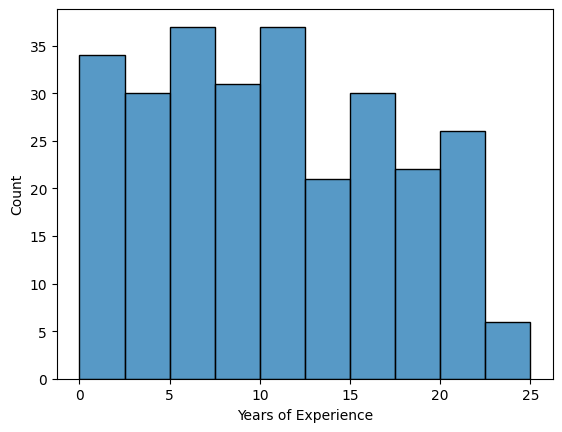

In [731]:
#Solution 4: remove outliers
# first let's visualize the outliers

#
sns.histplot(x=data_encoded['Years of Experience'])

#this dataset is not normally distributed

# individually work: 
IQR = data_encoded['Salary'].quantile(0.75) - data_encoded['Salary'].quantile(0.25)

#individually work: 
lower_bound= data_encoded['Salary'].quantile(0.25)-(IQR*1.5)
#individually work: 
upper_bound= data_encoded['Salary'].quantile(0.75)+(IQR*1.5)





<Axes: ylabel='Salary'>

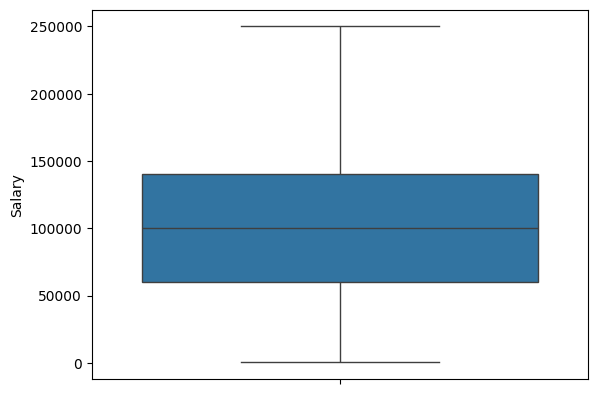

In [732]:
# see outliers
sns.boxplot(data_encoded['Salary'])



In [733]:
#trimming -delete the outlier data
## way to look individually
new_df = data_encoded.loc[(data_encoded['Salary'] < upper_bound) & (data_encoded['Salary'] > lower_bound) ]
print("before removing outliers: ", len(data))
print("after removing outliers: ", len(new_df))
print("outliers: ", len(data) - len(new_df))


#important fact: ONLY NUMERIC DATA is considered when removing outliers, not catergoical data

before removing outliers:  274
after removing outliers:  274
outliers:  0


In [734]:
#Solution 5: combine highely correlated data 
columns = ['Age', 'Salary', 'Years of Experience']
corr = data[columns].corr()

print(corr)

                          Age    Salary  Years of Experience
Age                  1.000000  0.902580             0.977241
Salary               0.902580  1.000000             0.911253
Years of Experience  0.977241  0.911253             1.000000


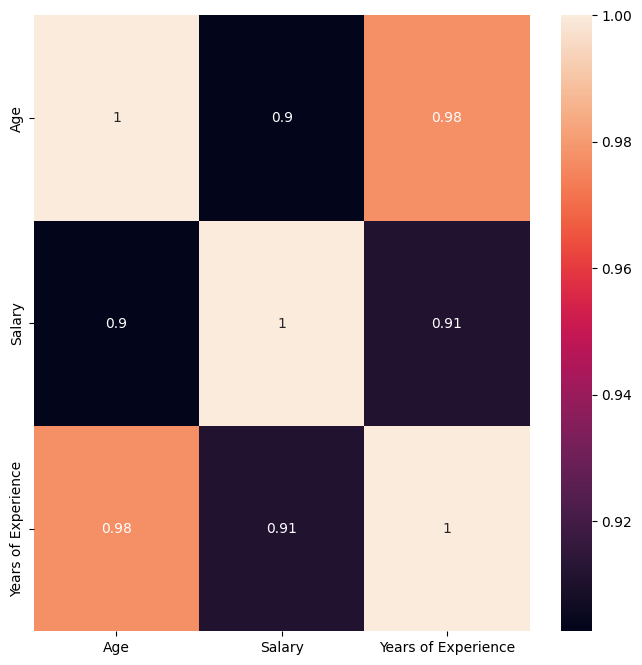

In [735]:
plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True)

plt.show()

In [736]:
#lets find correlation among catergoical variables in python

from scipy.stats import chi2_contingency

def is_correlated(x,y):
    crossl= pd.crosstab(index=data[x], columns=data[y])
    chi_sq_result= chi2_contingency(crossl)
    p_value = chi_sq_result[1]
    correlation_statement= "correlated" if p_value < 0.05 else "not-corelated"
    print(f"P-value: {p_value:}, The variables are {correlation_statement}.")




In [737]:
is_correlated('edu_level', 'gend')
#no correlation


P-value: 0.5692879591802311, The variables are not-corelated.


In [738]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor





In [739]:
#now time to split our data
#however first we need to identify x and y 

x=data_encoded.drop('Salary', axis=1)
y=data_encoded["Salary"]

##to esnure whats going on
##print(x)
##print(y)
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.7,random_state=42, shuffle=True)


#random_state matters?


In [740]:
import xgboost as xgb

xgb_train= xgb.DMatrix(x_train,label=y_train)
xgb_test = xgb.DMatrix(x_test, label=y_test)



In [741]:

params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'n_estimators': 12,
    'max-depth': 3,
    
}
 


In [742]:
xgb_model = xgb.XGBRegressor(**params)


In [743]:
xgb_model.fit(x_train, 
        y_train, 
        verbose=False,
        eval_set= [(x_train, y_train)],
        early_stopping_rounds= 3
        )
 


C:\Users\micri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\micri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [01:20:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max-depth" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max-depth=3,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=12, n_jobs=None,
             num_parallel_tree=None, ...)

In [744]:
predictions = xgb_model.evals_result()
predictions

{'validation_0': OrderedDict([('rmse',
               [44184.92666847374,
                40407.35190131141,
                37013.61197236908,
                33973.21689202219,
                31247.179336802532,
                28812.172275683864,
                26635.277291424813,
                24694.491001957384,
                22942.81380145405,
                21394.895670210724,
                19978.817945385726,
                18719.211869583487])])}

In [745]:
y_train_pred=xgb_model.predict(x_train)
y_train_pred

array([133995.42 , 121861.94 , 144778.28 , 102626.06 ,  75397.28 ,
        95278.945, 109723.93 ,  69736.19 ,  66188.35 ,  95120.88 ,
       137962.08 ,  85929.59 ,  60779.883,  93188.19 , 101109.13 ,
       114141.52 , 144778.28 ,  59702.742,  80433.14 , 135236.69 ,
       156165.98 ,  97608.234,  72045.62 , 157028.42 , 153682.69 ,
       103346.34 , 101613.72 , 146597.11 , 150394.67 , 131769.3  ,
       156165.98 ,  95471.15 ,  66188.35 , 157028.42 , 101109.13 ,
       101034.14 ,  80433.14 ,  60779.883,  94966.875,  69736.19 ,
        69736.19 , 107603.05 , 113629.24 ,  70558.54 ,  98947.77 ,
       132122.28 ,  98452.79 ,  89343.86 ,  81729.32 , 132480.97 ,
       120232.04 , 118961.13 , 157028.42 , 102626.06 ,  58590.6  ,
        59702.742,  78996.695, 111590.69 , 156165.98 ,  72229.195,
       101034.14 , 146477.14 ,  60779.883, 130762.58 ,  78218.84 ,
       145206.36 ,  65852.3  , 146804.67 , 124580.58 ,  94719.02 ,
       113845.82 , 157028.42 , 112736.9  , 118961.13 , 133681.

In [746]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

score = r2_score(y_train,y_train_pred)

print("R^2 - {}%".format(round(score,2)*100))


mae = mean_absolute_error(y_train,y_train_pred)
print('Mean Absolute Error:', mae)

# Calculate MSE
mse = mean_squared_error(y_train,y_train_pred)
print('Mean Squared Error:', mse)

R^2 - 85.0%
Mean Absolute Error: 14597.463718913612
Mean Squared Error: 350408892.68086874


In [747]:
y_pred=xgb_model.predict(x_test)
y_pred

array([133995.42 , 107603.05 , 101109.13 ,  99783.805,  75397.28 ,
        95120.88 ,  67675.414,  98452.79 ,  94018.4  , 111590.69 ,
       112736.9  ,  65852.3  ,  58590.6  ,  78996.695, 107603.05 ,
       143660.1  ,  91856.5  ,  98947.77 , 118816.11 ,  83816.555,
       146804.67 , 109104.06 ,  72045.62 , 150394.67 , 157028.42 ,
        93789.195,  75656.555, 117984.99 , 104726.38 , 166095.08 ,
        60779.883, 148839.38 , 117984.99 ,  60779.883,  58590.6  ,
        96757.07 ,  80433.14 ,  71223.266, 111221.63 ,  89343.86 ,
       104726.38 ,  66188.35 , 102626.06 ,  65852.3  , 113629.24 ,
       107603.05 , 126642.77 , 148839.38 , 133995.42 , 148839.38 ,
        85301.7  , 118816.11 ,  60779.883, 121074.1  ,  66188.35 ,
        74658.28 , 157028.42 , 110460.22 , 144778.28 , 157028.42 ,
        94018.4  , 157028.42 ,  58590.6  , 111590.69 ,  96195.61 ,
       101109.13 ,  58590.6  , 153682.69 ,  98452.79 ,  93188.19 ,
       165232.64 ,  90407.33 ,  80433.14 ,  65852.3  ,  58590.

In [748]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

score = r2_score(y_test,y_pred)

print("R^2 - {}%".format(round(score,2)*100))


mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)


R^2 - 74.0%
Mean Absolute Error: 16996.508047816264
Mean Squared Error: 545013930.0871172


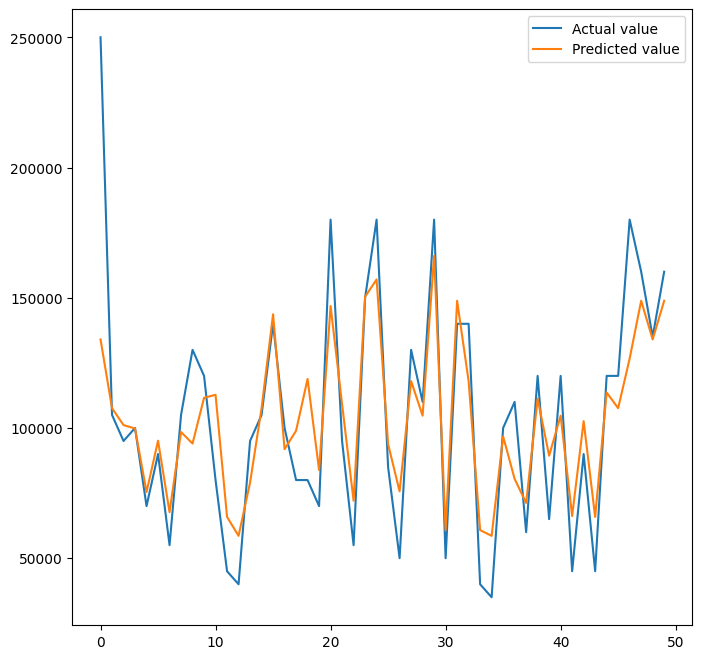

In [749]:
graph_check_df=pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

graph_check_df 


fig = plt.figure(figsize=(8,8))
graph_new=graph_check_df.reset_index()
graph_new_new=graph_new.drop(['index'],axis=1)
plt.plot(graph_new_new[:50])
plt.legend(['Actual value', 'Predicted value'])